## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


Из личных интересов выберу "Евгения Онегина"

In [9]:
import string
import os
from sklearn.model_selection import train_test_split
import re
import numpy as np

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [10]:
# if not os.path.exists('sonnets.txt'):
#     !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

# with open('sonnets.txt', 'r') as iofile:
#     text = iofile.readlines()

# TEXT_START = 45
# TEXT_END = -368
# text = text[TEXT_START : TEXT_END]
# assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [11]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

# assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
# assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
# print('OK!')

### Data loading: "Евгений Онегин"


In [12]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]

--2023-12-23 14:05:45--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.1’

onegin.txt.1        100%[===================>] 256.37K  --.-KB/s    in 0.007s  

2023-12-23 14:05:45 (35.4 MB/s) - ‘onegin.txt.1’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

сразу же избавимся от мусора с помощью регулярных выражений

In [13]:
text = ''.join(text).lower()

text = re.sub('[^\nа-я ]', '', text)
text = re.sub(' +', ' ', text)
text = re.sub('\n\n+', '\n\n', text)
separate_chars = list(filter(bool, text.split('\n\n')))
lines = text.split('\n')
lines = list(filter(bool, lines))

lines хранит списсок из строк. По сути потом именно их мы и будем отправлять в модель

Put all the characters, that you've seen in the text, into variable `tokens`.

In [14]:
tokens = sorted(set(text))

Note: Хорошо почистили текст, избавились от латиницы, остались только пробелы и переносы строк.

In [15]:
print(tokens)

['\n', ' ', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я']


Добавим два спец символа в токены для обозначания начала и конца строки

In [16]:
tokens.append('^')
tokens.append('$')

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [17]:
# dict <index>:<char>
token_to_id = {char : i for i, char in enumerate(tokens)}

# dict <char>:<index>
id_to_token = {i : char for i, char in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [18]:
train_chars, test_chars = train_test_split(separate_chars, test_size=0.2, random_state=69)
train_lines, test_lines = train_test_split(lines, test_size=0.2, random_state=65)

In [19]:
# encode our charactes

def to_matrix(lines, max_len=None):
    """Casts a list of lines into rnn-digestable matrix"""

    max_len = max_len or max(map(len, lines))
    matrix = np.zeros([len(lines), max_len + 2], dtype=int)
    matrix[:, 0] = token_to_id['^']
    for i in range(len(lines)):
        idx = [token_to_id[c] for c in lines[i]]
        matrix[i, 1:len(idx)+1] = idx
        matrix[i, len(idx) + 1:] = token_to_id['$']

    return matrix

to_matrix(lines[: 7])

array([[34, 14, 16, 11,  1,  6, 33,  6, 33,  1, 19,  2, 14, 29, 23,  1,
        25,  7, 19, 20, 15, 29, 23,  1, 17, 18,  2,  4, 10, 13, 35, 35],
       [34, 12, 16,  5,  6,  2,  1, 15,  7,  1,  4,  1, 26, 21, 20, 12,
        21,  1,  9,  2, 15,  7, 14, 16,  5, 35, 35, 35, 35, 35, 35, 35],
       [34, 16, 15,  1, 21,  4,  2,  8,  2, 20, 30,  1, 19,  7,  3, 33,
         1,  9,  2, 19, 20,  2,  4, 10, 13, 35, 35, 35, 35, 35, 35, 35],
       [34, 10,  1, 13, 21, 25, 26,  7,  1,  4, 29,  6, 21, 14,  2, 20,
        30,  1, 15,  7,  1, 14, 16,  5, 35, 35, 35, 35, 35, 35, 35, 35],
       [34,  7,  5, 16,  1, 17, 18, 10, 14,  7, 18,  1,  6, 18, 21,  5,
        10, 14,  1, 15,  2, 21, 12,  2, 35, 35, 35, 35, 35, 35, 35, 35],
       [34, 15, 16,  1,  3, 16,  8,  7,  1, 14, 16, 11,  1, 12,  2, 12,
         2, 33,  1, 19, 12, 21, 12,  2, 35, 35, 35, 35, 35, 35, 35, 35],
       [34, 19,  1,  3, 16, 13, 30, 15, 29, 14,  1, 19, 10,  6,  7, 20,
        30,  1, 10,  1,  6,  7, 15, 30,  1, 10,  1, 15, 16

Отлично, немного изменив функцию из нотбука с класса получаем некоторый аналог эмбедингов для символов

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

Заимпортим торч и будем с ним работать

In [20]:
import torch
from torch import nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

Построим простую RNN по аналогии с занятия

In [21]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, embedding_size=64, hidden_size=128):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.Sequential(
            nn.Linear(embedding_size + hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
        )
        self.decoder = nn.Linear(hidden_size, input_size)

    def forward(self, input, hidden):
        input = self.encoder(input)
        rnn_input = torch.cat([input, hidden], dim=1)
        hidden_next = self.rnn(rnn_input)
        output = self.decoder(hidden_next)
        return hidden_next, output

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size, requires_grad=True)

In [22]:
def rnn_batch(char_rnn, batch_ix, device):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hidden = char_rnn.init_hidden(batch_size).to(device)
    logprobs = []

    for x_t in batch_ix.transpose(0, 1):
        hidden, output = char_rnn(x_t, hidden)  # <-- here we call your one-step code
        logprobs.append(output)

    return torch.stack(logprobs, dim=1)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [23]:
model = SimpleRNN(input_size=len(token_to_id))
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
loader = DataLoader(train_lines, batch_size=30, shuffle=True)

model = model.to(device)

epochs = 50

train_loss = []
test_loss = []

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(loader):
        batch = to_matrix(data)
        batch = torch.tensor(batch, dtype=torch.int64).to(device)
        logp_seq = rnn_batch(model, batch, device)
        predictions_logp = logp_seq[:, :-1].contiguous().view(-1, len(tokens))
        actual_next_tokens = batch[:, 1:].flatten()

        loss = criterion(predictions_logp, actual_next_tokens)
        running_loss += loss.item()

        # train with backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        batch = to_matrix(test_lines)
        batch = torch.tensor(batch, dtype=torch.int64).to(device)

        seq = rnn_batch(model, batch, device)
        predictions = seq[:, :-1].contiguous().view(-1, len(tokens))
        actual = batch[:, 1:].flatten()
        test_loss_tmp = criterion(predictions, actual)
        test_loss.append(test_loss_tmp.item() / len(test_lines))

    train_loss_tmp = running_loss / len(loader.dataset)
    train_loss.append(train_loss_tmp)
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss_tmp}, Test Loss: {test_loss[-1]}')

Epoch [1/50], Train Loss: 0.07379689111720934, Test Loss: 0.0018447891387649363
Epoch [2/50], Train Loss: 0.07264214282086856, Test Loss: 0.0018713189848475584
Epoch [3/50], Train Loss: 0.07521832423034377, Test Loss: 0.0018738772252666633
Epoch [4/50], Train Loss: 0.07379256729280198, Test Loss: 0.001866313214537762
Epoch [5/50], Train Loss: 0.0740091560003165, Test Loss: 0.0018588267125104316
Epoch [6/50], Train Loss: 0.07371102527545834, Test Loss: 0.001898707885705926
Epoch [7/50], Train Loss: 0.07385017594032424, Test Loss: 0.0019136778302065772
Epoch [8/50], Train Loss: 0.07383073181374603, Test Loss: 0.0019142194845830534
Epoch [9/50], Train Loss: 0.07398594420815195, Test Loss: 0.0018679662802373502
Epoch [10/50], Train Loss: 0.07411213454111577, Test Loss: 0.001867719816164372
Epoch [11/50], Train Loss: 0.07370309773013084, Test Loss: 0.0018677615167523517
Epoch [12/50], Train Loss: 0.07331344911232857, Test Loss: 0.0018748614951231634
Epoch [13/50], Train Loss: 0.073695587970

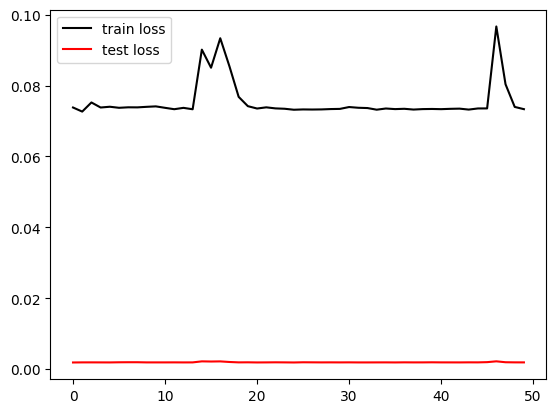

In [24]:
plt.plot(train_loss, label='train loss', color='black')
plt.plot(test_loss, label='test loss', color='red')
plt.legend()
plt.show()

In [25]:
def generate_sample(char_rnn, seed_phrase=' Hello', max_length=100, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function

    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
        smaller temperature converges to the single most likely output.

    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''

    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.init_hidden(batch_size=1).to(device)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        # print(x_sequence[:, -1].shape, hid_state.shape)
        hid_state, out = char_rnn(x_sequence[:, i], hid_state)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        # print(x_sequence.shape, x_sequence, hid_state.shape)
        hid_state, out = char_rnn(x_sequence[:, -1], hid_state)
        out = out.cpu()
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        # print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        # print(x_sequence.shape, next_ix.shape)
        x_sequence = x_sequence.cpu()
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)


    raw_predict = ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])
    return raw_predict.replace('^', '').replace('$', '')

In [26]:
for t in [i for i in np.arange(0.1, 3, 0.1)]:
    print('Temperature: ', t)
    for i in range(4):
        model.eval()
        print(generate_sample(model, seed_phrase='^а', max_length=100, temperature=t))

Temperature:  0.1
а се не но но се по се се нот во на на не но не на но ве по се по се на но но пе по се пона не се н
а но се мо на се по по но но не не не на се во по ней не по но по се но по но де на воне не се на н
а се во но но не но не то на се на се се но по но се но не но не се на се се но не на со се но не н
а се не не не но не не нон во но во се ней се се но се се ва по се се не на но сро но не ве ной во 
Temperature:  0.2
а не на ве по со се ве но со но со се и но но ве пот пот се пой ме на вас сро ка по се се по поно с
а не сот но неней ва се те нос нон ве вет ке нело но то ноно ной сра се не да не до ко но пот срос 
а пе воле се во но кет се по се но нот оно но то доне се на пом не те се та мо но но ней те нет по 
а по ней но во се пе с дот во но о пос ко не с со сет во по пе пот пос о пол с о се се но сдо се на
Temperature:  0.30000000000000004
а моли то тена ко ки но се па ос со по сле на нолай
а те ве со и со дас ов до трена по поре с тас под сдот си нале но ма мен пос д

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [27]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, embedding_size=64, hidden_size=128):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTMCell(embedding_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)

    def forward(self, input, hidden):
        input = self.encoder(input)
        h_1, c_1 = self.lstm(input, (hidden[0], hidden[1]))
        output = self.decoder(c_1)
        return (h_1, c_1), output

    def init_hidden(self, batch_size):
        return torch.zeros(2, batch_size, self.hidden_size, requires_grad=True)

Plot the loss function of the number of epochs. Does the final loss become better?

In [28]:
model_lstm = SimpleLSTM(input_size=len(token_to_id))
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001, weight_decay=0.001)
loader = DataLoader(train_lines, batch_size=30, shuffle=True)

model_lstm = model_lstm.to(device)

epochs = 50

train_loss = []
test_loss = []

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(loader):
        batch = to_matrix(data)
        batch = torch.tensor(batch, dtype=torch.int64).to(device)
        logp_seq = rnn_batch(model_lstm, batch, device)
        predictions_logp = logp_seq[:, :-1].contiguous().view(-1, len(tokens))
        actual_next_tokens = batch[:, 1:].flatten()

        loss = criterion(predictions_logp, actual_next_tokens)
        running_loss += loss.item()

        # train with backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        batch = to_matrix(test_lines)
        batch = torch.tensor(batch, dtype=torch.int64).to(device)

        seq = rnn_batch(model_lstm, batch, device)
        predictions = seq[:, :-1].contiguous().view(-1, len(tokens))
        actual = batch[:, 1:].flatten()
        test_loss_tmp = criterion(predictions, actual)
        test_loss.append(test_loss_tmp.item() / len(test_lines))

    train_loss_tmp = running_loss / len(loader.dataset)
    train_loss.append(train_loss_tmp)
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss_tmp}, Test Loss: {test_loss[-1]}')

Epoch [1/50], Train Loss: 0.07743991651659772, Test Loss: 0.0017056105934621717
Epoch [2/50], Train Loss: 0.06510279445103885, Test Loss: 0.0016159051498079481
Epoch [3/50], Train Loss: 0.06311930376907875, Test Loss: 0.001578538476740906
Epoch [4/50], Train Loss: 0.0617853358015861, Test Loss: 0.0015580548759649008
Epoch [5/50], Train Loss: 0.060673899599544785, Test Loss: 0.0015410286845363138
Epoch [6/50], Train Loss: 0.06044334509143081, Test Loss: 0.0015285664411552051
Epoch [7/50], Train Loss: 0.05958736801827847, Test Loss: 0.0015230653630463342
Epoch [8/50], Train Loss: 0.05945659554103892, Test Loss: 0.001505928687722964
Epoch [9/50], Train Loss: 0.05913608740399482, Test Loss: 0.0015233091075157485
Epoch [10/50], Train Loss: 0.058822472937467125, Test Loss: 0.0014964897369703866
Epoch [11/50], Train Loss: 0.058637367700991816, Test Loss: 0.0014924756021100758
Epoch [12/50], Train Loss: 0.05838814328881988, Test Loss: 0.0014873469963726435
Epoch [13/50], Train Loss: 0.05836490

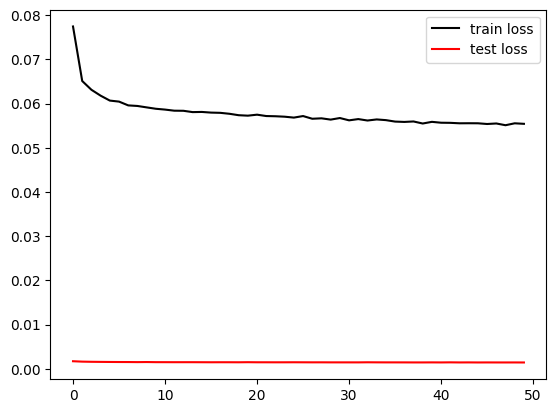

In [29]:
plt.plot(train_loss, label='train loss', color='black')
plt.plot(test_loss, label='test loss', color='red')
plt.legend()
plt.show()

Лосс выглядит примерно также как и для rnn

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [30]:
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print('Temperature: ', t)
    for i in range(4):
        model_lstm.eval()
        print(generate_sample(model_lstm, seed_phrase='^а', max_length=100, temperature=t))

Temperature:  0.1
а стали с нем не володал
а стали с нем не володой
а старит с нем не волода
а так не странный странный стран
Temperature:  0.2
а то не пред не поленный
а посторой не света странье
а просто подуша сворой
а страсти поло подолон
Temperature:  0.5
а тольно прилить не молон
а что молгита но любой
а дем и молоди мерави
а прод онего залинала
Temperature:  1.0
а свялитым пошы ум кака
амдорит еел вмож и от ж
ался подят бам уразала
атскаянный встар леской твор
Temperature:  2.0
а нияни мещоль озчесзмилвьфогетъмичилься мидтыйти уз
апрыстоюбэчтмлю щомушнийяхпевисьж жныдейсипяк оухй
анубемнун фрухи тыхотвялиишибегсумакицйъбы сьопда
али ужегрещыю обуьщивеярзайщсолэдне б


In [31]:
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print('Temperature: ', t)
    for i in range(4):
        model.eval()
        print(generate_sample(model, seed_phrase='^а', max_length=100, temperature=t))

Temperature:  0.1
а но пот по со но по во по не се се во по се но се на не во но се се на со но се но но но но те но 
а се се те не не не пот се со по се пос се на се во но но се се на но со се но но те то но не но но
а во на но но пос се но по пон во ве но но но но на на но по по се но на не се но на се се но се по
а со се но не не но но но се се ней с пот во со но но но во со та со се но на не ве на не на не во 
Temperature:  0.2
а поно да сет ко на по сдой по со во по сот се воне сена на со ней со пот вена ке се се те но но се
а на се те на но на ней се си ной те не ка но ве тет со за на се по се пе со то вет ве не та те нол
а не да по те во се со ко но ной най ве се пос со на со пот пот но се но сво со та на пово не не та
а вен ва но на на ко сро вос ве пот то дос воно се се ной пел сс не но рос сос сне нер по си ве но 
Temperature:  0.5
а ту чай вессу ни стис
а нодей  у ол та на р вой пе той мо бе волен сегеже вой п мел лан ла вол
ае той сю ну но мевь
але се сротель дой с вой те н

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [32]:
torch.save(model, 'model.pt')
torch.save(model_lstm, 'model_lstm.pt')

In [33]:
model_loaded = torch.load('model.pt')
model_lstm_loaded = torch.load('model_lstm.pt')

In [34]:
generate_sample(model_lstm_loaded, seed_phrase='^у', max_length=100, temperature=0.1)

'у стали с ней не своей свет'

In [35]:
generate_sample(model_loaded , seed_phrase='^у', max_length=100, temperature=0.1)

'у се се но се но но се на на во ве се со се се по по по со но ве сро но не но ной се не на по но но'

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)